## Classification of Irrigated/Rainfed In Madison Country using DecisionTreeClassifier

In this project, we are trying to solve the problem of classifying the fields as irrigated or rainfed using DecisionTreeClassifier.

### Libraries used:

1. Numpy
2. Pandas
3. Matplotlib for visualization and plotting


### The classification problem was solved following the steps given below:

1. Data Preprocessing and Cleaning 
2. Split data into 3 chunks using stratified sampling 
3. Handle skewness using smote algorithm in the training set
4. Apply decision tree algorithm
5. Model selection using validation set and accuracy-depth plot
6. Evaluation of result on test dataset.


In [1]:
# Import libraries
%matplotlib inline

# Import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import data preprocessing algorithms implemented from scratch
from src.data_preprocessing.data_split import Stratify
from src.data_preprocessing.over_sample import SMOTE
from src.data_preprocessing.pca import PCA
from src.data_preprocessing.standardize import Standardize

# Implementation of decision tree algorithm and pruning
from src.decision_tree.decision_tree import DecisionTree
from src.decision_tree.pruning import *

# Evaluation metric for test set
from src.evaluation.evaluation import Metrics

In [2]:
## Read dataset
df_1 = pd.read_excel(r'data/Madison_Irrigated_2.xls')
df_2 = pd.read_excel(r'data/Madison_Rainfed_2.xls')

### Data Preprocessing and Cleaning:
The following steps were carried out for data preprocessing and cleaning:

i. Missing values were handled using linear interpolation.

ii. As the dataset was imbalanced (containing {1: 1288, 0: 5053}), it was handled using an oversampling algorithm: Smote.

iii. The data was standardized using z-score normalization.

iv. PCA was used for dimensionality reduction. (As using principal components with more than 95% resulted in overfitting from even a small decision tree, 91% variance were preserved while performing the dimensionality reduction with only 10 principal components.)


In [3]:
## Remove unnecessary column
df_concat = pd.concat([df_1, df_2], ignore_index=True)
df_concat.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
## Handle missing values using linear interpolation
df_interpolate=df_concat.interpolate(ignore_index=True)

In [5]:
## Divide into feature and target set
X = df_interpolate.loc[ : , df_interpolate.columns != 'Irr_Rf']
y = df_interpolate['Irr_Rf']

Text(0.5, 1.0, 'Data Distribution')

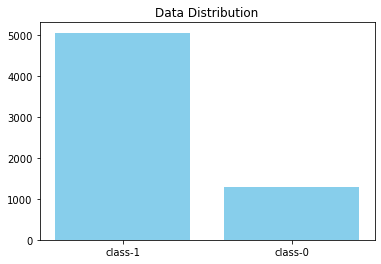

In [6]:
# Imbalanced data set
unique, counts = np.unique(y, return_counts=True)
y_count = dict(zip(unique, counts))
plt.bar(y_count.keys(), y_count.values(), color="skyblue", tick_label =['class-1','class-0'])
plt.title('Data Distribution')

### Standardize

In [9]:
# Standardize data using z-score
X_scaled = Standardize(X).compute_z_score()

### Dimensionality reduction using PCA

In [10]:
# Apply PCA preserving 91 % of the total variance
X_reduced = PCA(num_components=10).fit_transform(X_scaled)

### Preprocessed Dataframe

In [11]:
# Dataframe containing the standardized data with its 14 principal components
df_preprocessed = pd.DataFrame(X_reduced, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10'])
df_preprocessed['label'] = y

In [12]:
#Shuffle preprocessed dataframe
df_shuffled = df_preprocessed.sample(frac=1)
df_shuffled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,label
1761,-0.538524,-0.351136,0.497024,-1.511919,-1.839685,-0.723397,-0.202246,0.171679,-0.515342,0.168363,0
4309,-1.537559,-2.337141,-0.770379,0.317641,-0.030802,0.256151,-0.026440,-0.568370,-0.159158,-0.572335,0
1367,-1.377926,1.537184,-0.699582,-1.642701,-0.252358,-1.165974,0.711601,-0.276098,-0.506763,1.136272,0
5099,-1.216717,-1.546197,0.136175,-0.704046,-1.139946,-1.947301,0.403808,-0.091773,0.023081,0.191256,0
5165,-0.042709,0.091528,-0.505165,1.936668,0.440784,-0.572569,0.005919,-0.833031,0.468814,-0.421563,0


### Split into train, validation and test set

After data preprocessing and cleaning, the data were splitted into three chunks: train, validation and test containing 70%, 20% and 10% of total data respectively using stratified sampling. Thereafter, the data were shuffled in each of these sets.


In [13]:
# Add 10% of shuffled data to test set
df_train, df_test = Stratify(df_shuffled, 'label', 0.1).train_test_split()

In [14]:
# Add 20% of shuffled data to val set and remaining (80%) to train set
df_train, df_val = Stratify(df_shuffled, 'label', 0.2).train_test_split()

In [15]:
X_new = df_train.loc[ : , df_train.columns != 'label']
y_new = df_train['label']

### Handle skewness

In [18]:
sm = SMOTE(dims=10)
X_res, y_res = sm.fit_transform(X_new.values,y_new.values)

In [32]:
df_train_final = pd.DataFrame(X_res, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10'])
df_train_final['label'] = y_res

Text(0.5, 1.0, 'Data Distribution')

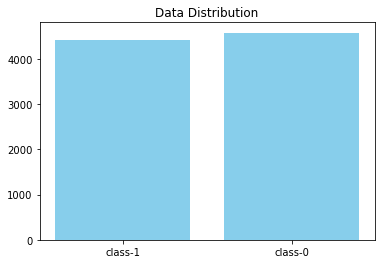

In [34]:
unique, counts = np.unique(df_train_final['label'], return_counts=True)
y_count = dict(zip(unique, counts))
plt.bar(y_count.keys(), y_count.values(), color="skyblue", tick_label =['class-1','class-0'])
plt.title('Data Distribution')

### Apply decision tree algorithm

In [35]:
acc_train = []
acc_test = []
acc_val = []
i_values = []

In [38]:
import time
print("Decision Tree - Irrigated/Rainfed In Madison Country")
i = 1
accuracy_train = 0
while accuracy_train < 100:
    start_time = time.time()
    # Initialize decision tree
    tree = DecisionTree(max_depth = i)
    # Build the tree
    decision_tree = tree.build_decision_tree(df_train_final)
    building_time = time.time() - start_time
    decision_tree_val_results = tree.predictions(df_val, decision_tree)
    decision_tree_test_results = tree.predictions(df_test, decision_tree)
    accuracy_val = tree.calculate_accuracy(decision_tree_val_results, df_val.iloc[:, -1]) * 100
    accuracy_test = tree.calculate_accuracy(decision_tree_test_results, df_test.iloc[:, -1]) * 100
    decision_tree_train_results = tree.predictions(df_train_final, decision_tree) 
    accuracy_train = tree.calculate_accuracy(decision_tree_train_results, df_train_final.iloc[:, -1]) * 100
    print("maxDepth = {}: ".format(i), end = "")
    print("accTest = {0:.2f}%, ".format(accuracy_test), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracy_train), end = "")
    print("accVal = {0:.2f}%, ".format(accuracy_val), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    acc_train.append(accuracy_train)
    acc_val.append(accuracy_val)
    acc_test.append(accuracy_test)
    i_values.append(i)
    i += 1

Decision Tree - Irrigated/Rainfed In Madison Country
maxDepth = 1: accTest = 61.04%, accTrain = 61.99%, accVal = 61.75%, buildTime = 68.03s
maxDepth = 2: accTest = 64.35%, accTrain = 65.40%, accVal = 65.30%, buildTime = 119.99s
maxDepth = 3: accTest = 66.09%, accTrain = 68.33%, accVal = 65.77%, buildTime = 163.53s
maxDepth = 4: accTest = 70.50%, accTrain = 71.59%, accVal = 67.51%, buildTime = 189.19s
maxDepth = 5: accTest = 70.19%, accTrain = 73.21%, accVal = 68.69%, buildTime = 219.62s
maxDepth = 6: accTest = 72.56%, accTrain = 75.38%, accVal = 67.74%, buildTime = 233.68s
maxDepth = 7: accTest = 75.08%, accTrain = 79.34%, accVal = 68.69%, buildTime = 245.81s
maxDepth = 8: accTest = 76.97%, accTrain = 82.27%, accVal = 69.32%, buildTime = 240.14s
maxDepth = 9: accTest = 77.13%, accTrain = 85.02%, accVal = 69.16%, buildTime = 251.42s
maxDepth = 10: accTest = 79.97%, accTrain = 87.44%, accVal = 69.32%, buildTime = 268.94s
maxDepth = 11: accTest = 80.91%, accTrain = 89.91%, accVal = 69.24%

### Plot train and validation set accuracy and error graph

In [39]:
error_train = 1 - (np.array(acc_train)/100)
error_val = 1 - (np.array(acc_val)/100)
error_test = 1 - (np.array(acc_test)/100)

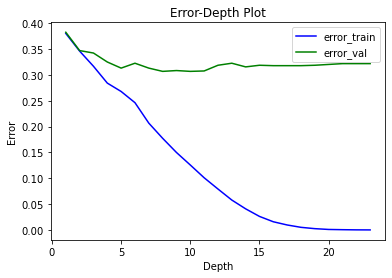

In [44]:
# Plotting the Graph
plt.plot(i_values, error_train, "-b", label="error_train")
plt.plot(i_values, error_val, "-g", label="error_val")
plt.title("Error-Depth Plot")
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

In [42]:
acc_train = np.array(acc_train)/100
acc_val = np.array(acc_val)/100
acc_test = np.array(acc_test)/100

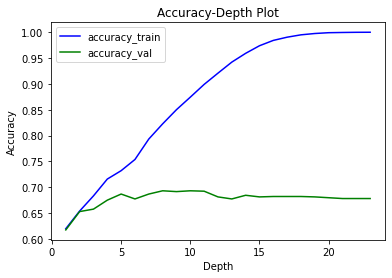

In [43]:
# Plotting the Graph
plt.plot(i_values, acc_train, "-b", label="accuracy_train")
plt.plot(i_values, acc_val, "-g", label="accuracy_val")
plt.title("Accuracy-Depth Plot")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Therefore, visualizing the training plot, max-depth=15 seems to be the correct model whereas while looking at the validation plot, max-depth=5 seems to be the correct model.

### Plot decision boundary

In this section, we are trying to visualize data around max-depth=5 and max-depth=15 to help select the best model.

In [63]:
X_train = df_train_final.values
y_train = df_train_final['label'].values

In [64]:
from itertools import product

# Loading data
X = X_train[:,:2]
y= y_train

In [49]:
# Plotting decision trees
clf3 = DecisionTree(max_depth=3)
clf4 = DecisionTree(max_depth=4)
clf5 = DecisionTree(max_depth=5)
clf6 = DecisionTree(max_depth=6)
clf14 = DecisionTree(max_depth=14)
clf15 = DecisionTree(max_depth=15)
clf16 = DecisionTree(max_depth=16)
clf17 = DecisionTree(max_depth=17)

c3 = clf3.build_decision_tree(df_train_final)
c4 = clf4.build_decision_tree(df_train_final)
c5 = clf5.build_decision_tree(df_train_final)
c6 = clf6.build_decision_tree(df_train_final)
c14 = clf14.build_decision_tree(df_train_final)
c15 = clf15.build_decision_tree(df_train_final)
c16 = clf16.build_decision_tree(df_train_final)
c17 = clf17.build_decision_tree(df_train_final)

### Decision Boundary on Training dataset

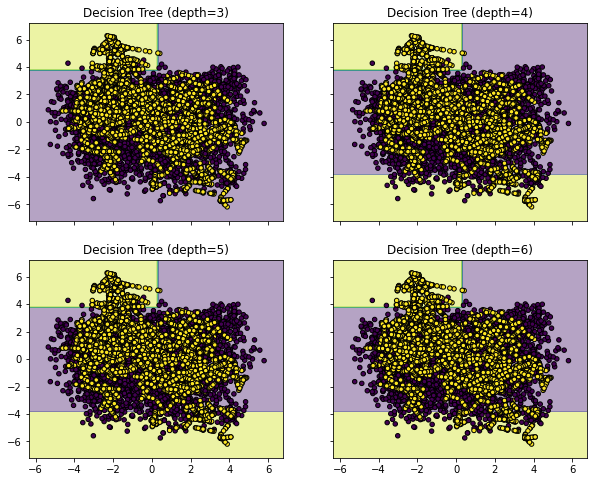

In [65]:
# Plotting decision boundaries for training set (depth- 5,6,7,8)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf3, clf4, clf5, clf6],
                        ['Decision Tree (depth=3)','Decision Tree (depth=4)','Decision Tree (depth=5)','Decision Tree (depth=6)'],[c3,c4,c5,c6]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

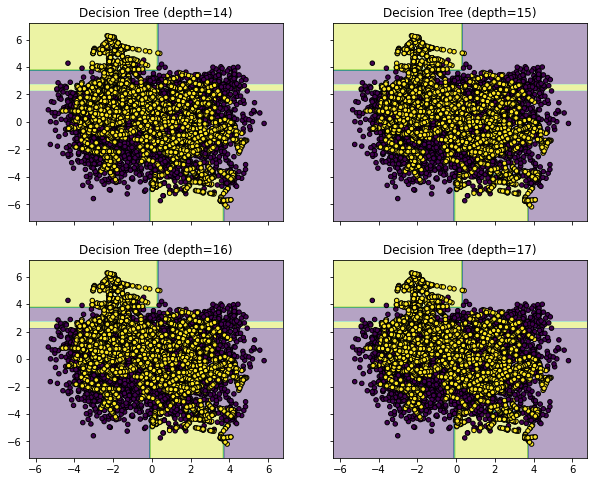

In [54]:
# Plotting decision boundaries for training set (depth - 9,10,11,12)
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf14, clf15, clf16, clf17],
                        ['Decision Tree (depth=14)','Decision Tree (depth=15)','Decision Tree (depth=16)','Decision Tree (depth=17)'],[c14,c15,c16,c17]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Decision Boundary on Validation dataset

In [91]:
X_val = df_val.values
y_val = df_val['label'].values

X = X_val[:,:2]
y= y_val

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

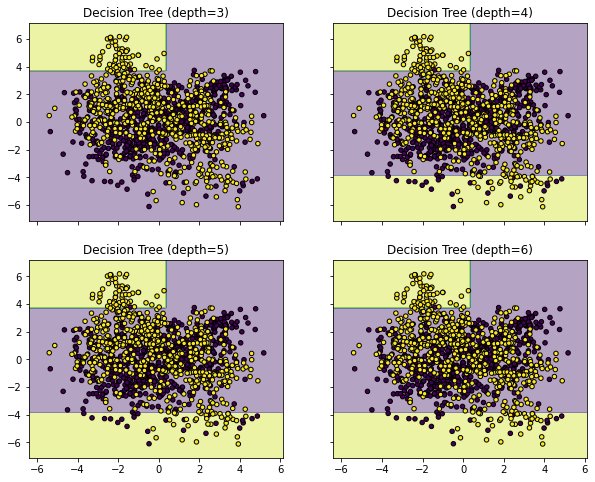

In [93]:
# Plotting decision boundaries for validation set (depth- 5,6,7,8)
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf3, clf4, clf5, clf6],
                        ['Decision Tree (depth=3)','Decision Tree (depth=4)','Decision Tree (depth=5)','Decision Tree (depth=6)'],[c3,c4,c5,c6]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

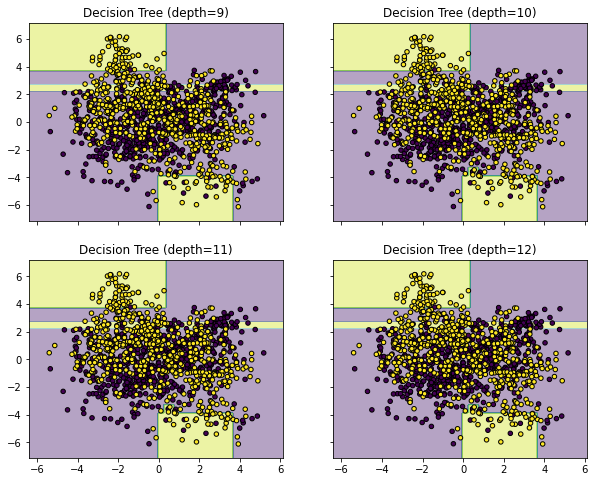

In [67]:
# Plotting decision boundaries for validation set (depth - 9,10,11,12)
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf14, clf15, clf16, clf17],
                        ['Decision Tree (depth=9)','Decision Tree (depth=10)','Decision Tree (depth=11)','Decision Tree (depth=12)'],[c14,c15,c16,c17]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Pruning the decision tree

In [58]:
c5

{'PC3 <= 2.01698085272447': [{'PC2 <= 3.724320189213132': [{'PC8 <= 0.34713819851525285': [{'PC2 <= -3.830829144110229': [{'PC6 <= 0.9642426768212335': [1.0,
          0.0]},
        0.0]},
      {'PC6 <= 0.24935772115142918': [{'PC9 <= -0.006163800662947843': [1.0,
          0.0]},
        1.0]}]},
    {'PC1 <= 0.3448380525363134': [{'PC9 <= -0.7465826694517675': [0.0,
        {'PC10 <= -1.270883359710674': [0.0, 1.0]}]},
      {'PC8 <= -0.9429530372139716': [1.0, 0.0]}]}]},
  {'PC6 <= -0.5923209052091465': [{'PC7 <= 0.21233068981024117': [{'PC1 <= 0.5357596542629881': [{'PC8 <= 1.8917507396556816': [0.0,
          1.0]},
        {'PC9 <= 0.20795693271261803': [0.0, 1.0]}]},
      {'PC9 <= 0.02811107358035988': [{'PC5 <= -1.1215649710916407': [0.0,
          1.0]},
        {'PC2 <= 0.9553639428688796': [0.0, 1.0]}]}]},
    {'PC8 <= 0.19000952050089764': [{'PC3 <= 2.538896711131528': [1.0,
        {'PC5 <= -1.965029922021348': [0.0, 1.0]}]},
      {'PC3 <= 3.1007115509230196': [{'PC7 <

In [59]:
tree_pruned = post_pruning(clf5, c5, df_train, df_val)
tree_pruned

{'PC3 <= 2.01698085272447': [{'PC2 <= 3.724320189213132': [{'PC8 <= 0.34713819851525285': [{'PC2 <= -3.830829144110229': [{'PC6 <= 0.9642426768212335': [1.0,
          0.0]},
        0.0]},
      {'PC6 <= 0.24935772115142918': [{'PC9 <= -0.006163800662947843': [1.0,
          0.0]},
        1.0]}]},
    {'PC1 <= 0.3448380525363134': [1, 0]}]},
  {'PC6 <= -0.5923209052091465': [{'PC7 <= 0.21233068981024117': [{'PC1 <= 0.5357596542629881': [{'PC8 <= 1.8917507396556816': [0.0,
          1.0]},
        {'PC9 <= 0.20795693271261803': [0.0, 1.0]}]},
      {'PC9 <= 0.02811107358035988': [{'PC5 <= -1.1215649710916407': [0.0,
          1.0]},
        {'PC2 <= 0.9553639428688796': [0.0, 1.0]}]}]},
    {'PC8 <= 0.19000952050089764': [1,
      {'PC3 <= 3.1007115509230196': [{'PC7 <= 0.20041911249044375': [0.0,
          1.0]},
        1]}]}]}]}

In [76]:
c15

{'PC3 <= 2.01698085272447': [{'PC2 <= 3.724320189213132': [{'PC8 <= 0.34713819851525285': [{'PC2 <= -3.830829144110229': [{'PC6 <= 0.9642426768212335': [{'PC7 <= 0.19597315411066354': [{'PC1 <= -0.07320763987337418': [{'PC7 <= 0.11430868848403934': [0.0,
                1.0]},
              {'PC10 <= 0.03822132422578686': [{'PC3 <= -0.1891952718960509': [{'PC10 <= 0.010918690604387422': [0.0,
                    1.0]},
                  {'PC4 <= 2.6454286340273905': [{'PC1 <= 3.676693079184104': [{'PC5 <= -1.921512009948625': [0.0,
                        {'PC2 <= -4.009802435706431': [{'PC10 <= -0.05203930168273435': [1.0,
                            {'PC10 <= -0.03496330666029368': [0.0, 1.0]}]},
                          {'PC4 <= -0.5013251802143533': [0.0,
                            {'PC6 <= -0.6790370236839172': [0.0, 1.0]}]}]}]},
                      0.0]},
                    0.0]}]},
                {'PC8 <= -0.5578957178255834': [1.0, 0.0]}]}]},
            {'PC8 <= -0.87145

In [77]:
tree_pruned_2 = post_pruning(clf15, c15, df_train, df_val)
tree_pruned_2

{'PC3 <= 2.01698085272447': [{'PC2 <= 3.724320189213132': [{'PC8 <= 0.34713819851525285': [{'PC2 <= -3.830829144110229': [{'PC6 <= 0.9642426768212335': [{'PC7 <= 0.19597315411066354': [{'PC1 <= -0.07320763987337418': [0,
              {'PC10 <= 0.03822132422578686': [1,
                {'PC8 <= -0.5578957178255834': [1.0, 0.0]}]}]},
            {'PC8 <= -0.8714505392907765': [1.0,
              {'PC3 <= 1.9028497414096885': [0.0, 1.0]}]}]},
          0]},
        {'PC2 <= -0.08690633927528024': [{'PC1 <= 0.2758981575591521': [{'PC5 <= 1.4613139151014336': [{'PC10 <= -0.9112841306868809': [0,
                {'PC6 <= 0.9970124977789625': [{'PC3 <= 1.9286088731434838': [{'PC2 <= -0.12413471140508514': [{'PC5 <= 1.0847540646783702': [{'PC6 <= 0.5228352327491523': [{'PC10 <= -0.833695082454498': [{'PC9 <= 0.6186361813662937': [0.0,
                              1.0]},
                            0.0]},
                          0]},
                        0]},
                      0]},
 

### Effect of pruning on training dataset

### When depth =5

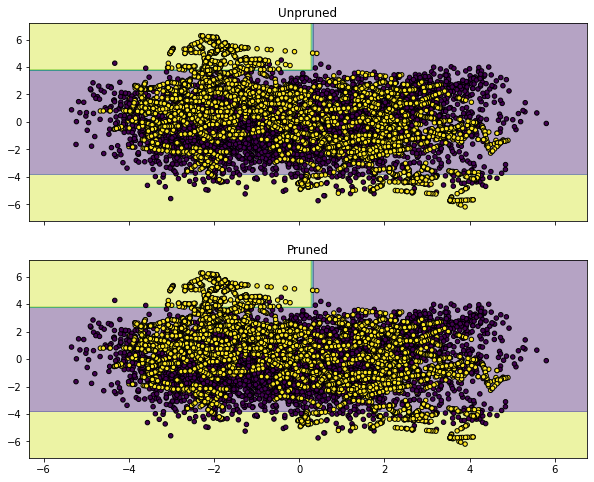

In [61]:
# Loading training data
X = X_train[:,:2]
y= y_train

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(range(0, 2),
                        [clf5, clf5],
                        ['Unpruned','Pruned'],[c5,tree_pruned]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

### Effect of pruning on validation dataset

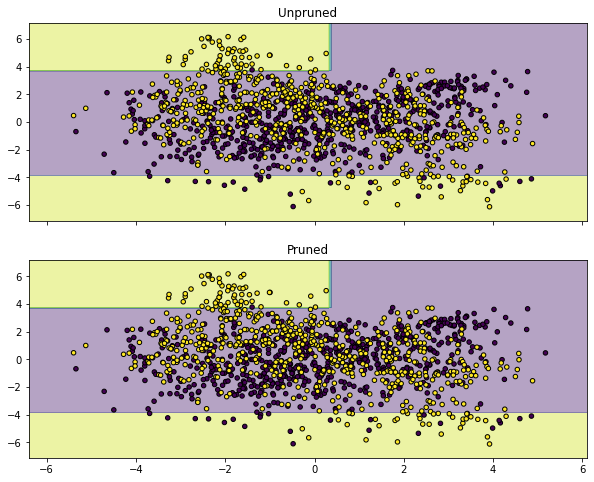

In [68]:
# Loading validation data
X = X_val[:,:2]
y= y_val

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(range(0, 2),
                        [clf5, clf5],
                        ['Unpruned','Pruned'],[c5,tree_pruned]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

### When depth =15

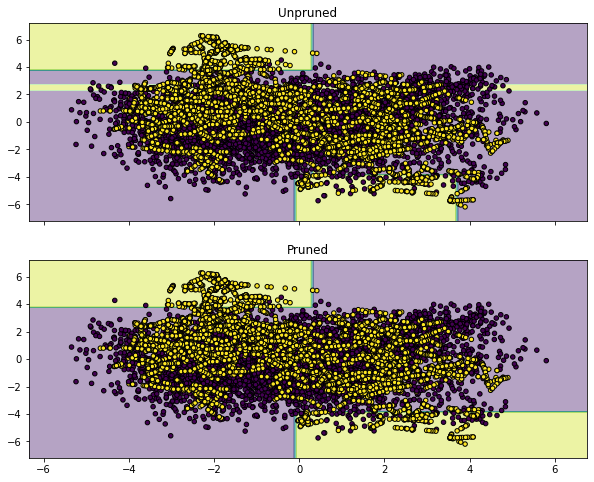

In [94]:
# Loading training data
X = X_train[:,:2]
y= y_train

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(range(0, 2),
                        [clf15, clf15],
                        ['Unpruned','Pruned'],[c15,tree_pruned_2]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140),np.zeros(19140)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

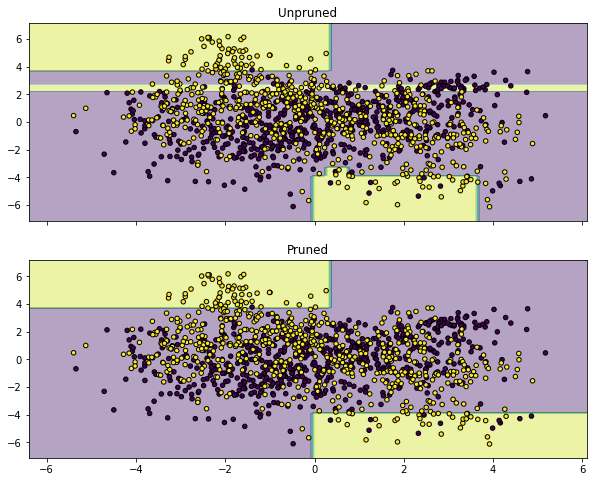

In [95]:
# Loading validation data
X = X_val[:,:2]
y= y_val

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(range(0, 2),
                        [clf15, clf15],
                        ['Unpruned','Pruned'],[c15,tree_pruned_2]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144),np.zeros(18144)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

### Result of both max-depth=15 and max-depth=5 in the validation dataset

In [89]:
pred_c5 = clf5.predictions(df_val, c5)
print(Metrics(df_val['label'], pred_c5).confusion_matrix())
Metrics(df_val['label'], pred_c5).report()

[[506 128]
 [269 365]]
Accuracy: 0.69
Precision (1): 0.74
Precision (0): 0.65
Recall (1): 0.58
Recall (0): 0.8
F1-score (1): 0.65
F1-score (0): 0.72


In [90]:
pred_pruned = clf5.predictions(df_val, tree_pruned)
print(Metrics(df_val['label'], pred_pruned).confusion_matrix())
Metrics(df_val['label'], pred_pruned).report()

[[506 128]
 [254 380]]
Accuracy: 0.7
Precision (1): 0.75
Precision (0): 0.67
Recall (1): 0.6
Recall (0): 0.8
F1-score (1): 0.67
F1-score (0): 0.73


In [87]:
pred_c15 = clf15.predictions(df_val, c15)
print(Metrics(df_val['label'], pred_c15).confusion_matrix())
Metrics(df_val['label'], pred_c15).report()

[[537  97]
 [307 327]]
Accuracy: 0.68
Precision (1): 0.77
Precision (0): 0.64
Recall (1): 0.52
Recall (0): 0.85
F1-score (1): 0.62
F1-score (0): 0.73


In [88]:
pred_c15_pruned = clf15.predictions(df_val, tree_pruned_2)
print(Metrics(df_val['label'], pred_c15_pruned).confusion_matrix())
Metrics(df_val['label'], pred_c15_pruned).report()

[[575  59]
 [262 372]]
Accuracy: 0.75
Precision (1): 0.86
Precision (0): 0.69
Recall (1): 0.59
Recall (0): 0.91
F1-score (1): 0.7
F1-score (0): 0.78


As decision tree with max-depth 15 produced better f1-score, we have selected decision-tree with max-depth 15 as the final model.

### Result on test dataset

Here, we are testing the result of selected model on the test dataset.

In [86]:
pred_c15_pruned = clf15.predictions(df_test, tree_pruned_2)
print(Metrics(df_test['label'], pred_c15_pruned).confusion_matrix())
Metrics(df_test['label'], pred_c15_pruned).report()

[[297  20]
 [102 215]]
Accuracy: 0.81
Precision (1): 0.91
Precision (0): 0.74
Recall (1): 0.68
Recall (0): 0.94
F1-score (1): 0.78
F1-score (0): 0.83


### Conclusion:

Hence, the data was first pre-processed and cleaned, standardized and pca was applied. After training with the decision tree classifier, we plotted the graph and found that there was a wide gap between training and validation accuracy. Thus, there was an overfitting. To handle that, we pruned the decision tree, and evaluated the result on a test (unseen) dataset.
